In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv
/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json
/kaggle/input/cassava-leaf-disease-classification/train.csv
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train14-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train13-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train04-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train01-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train08-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train00-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train10-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train02-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train15-1327.tf

In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

2025-06-08 17:16:48.421674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749403008.625724      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749403008.687570      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load labels
df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')
df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [4]:
with open('/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
    label_map = json.load(f)

df['label_name'] = df['label'].astype(str).map(label_map)

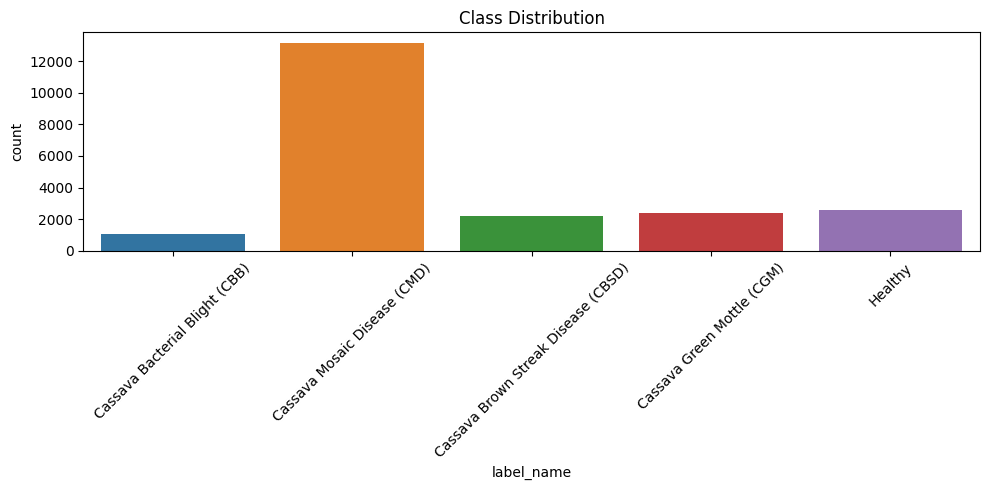

In [5]:
# Plot label distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='label_name', data=df)
plt.xticks(rotation=45)
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

In [6]:
train_df, val_df = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)

In [7]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='/kaggle/input/cassava-leaf-disease-classification/train_images',
    x_col='image_id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='sparse',
    batch_size=BATCH_SIZE
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory='/kaggle/input/cassava-leaf-disease-classification/train_images',
    x_col='image_id',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='sparse',
    batch_size=BATCH_SIZE
)

Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.


In [9]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze base layers
base_model.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1749403032.101499      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749403032.102180      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1749403051.083301      64 service.cc:148] XLA service 0x785a3814cf70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749403051.084087      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749403051.084109      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749403052.874144      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/535 ━━━━━━━━━━━━━━━━━━━━ 3:47:41 26s/step - accuracy: 0.1875 - loss: 1.7186

I0000 00:00:1749403061.735693      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


535/535 ━━━━━━━━━━━━━━━━━━━━ 423s 744ms/step - accuracy: 0.6058 - loss: 1.2090 - val_accuracy: 0.6150 - val_loss: 1.1946
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 259s 484ms/step - accuracy: 0.6186 - loss: 1.1857 - val_accuracy: 0.6150 - val_loss: 1.1965
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 248s 464ms/step - accuracy: 0.6095 - loss: 1.2038 - val_accuracy: 0.6150 - val_loss: 1.2032
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 237s 442ms/step - accuracy: 0.6163 - loss: 1.1925 - val_accuracy: 0.6150 - val_loss: 1.1836
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 239s 446ms/step - accuracy: 0.6139 - loss: 1.1925 - val_accuracy: 0.6150 - val_loss: 1.1793
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 253s 472ms/step - accuracy: 0.6145 - loss: 1.1924 - val_accuracy: 0.6150 - val_loss: 1.1821
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 250s 467ms/step - accuracy: 0.6101 - loss: 1.1989 - val_accuracy: 0.6150 - val_loss: 1.1780
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 242s 452ms/step - accuracy: 0.6106 - loss: 1.19

134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 188ms/step
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.00      0.00      0.00       217
Cassava Brown Streak Disease (CBSD)       0.00      0.00      0.00       438
         Cassava Green Mottle (CGM)       0.00      0.00      0.00       477
       Cassava Mosaic Disease (CMD)       0.61      1.00      0.76      2632
                            Healthy       0.00      0.00      0.00       516

                           accuracy                           0.61      4280
                          macro avg       0.12      0.20      0.15      4280
                       weighted avg       0.38      0.61      0.47      4280



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


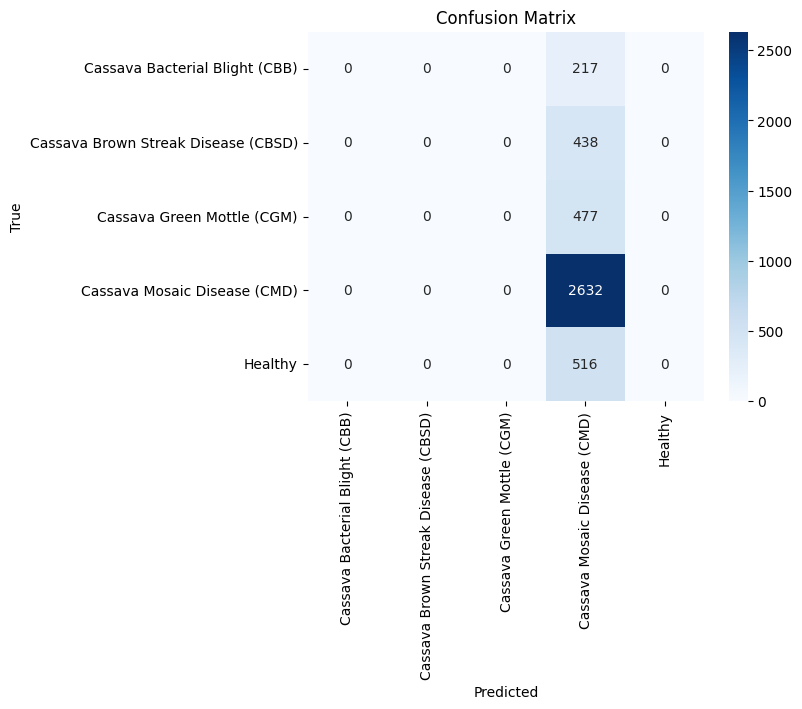

In [11]:
# Get true and predicted labels
val_generator.reset()
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=list(label_map.values())))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

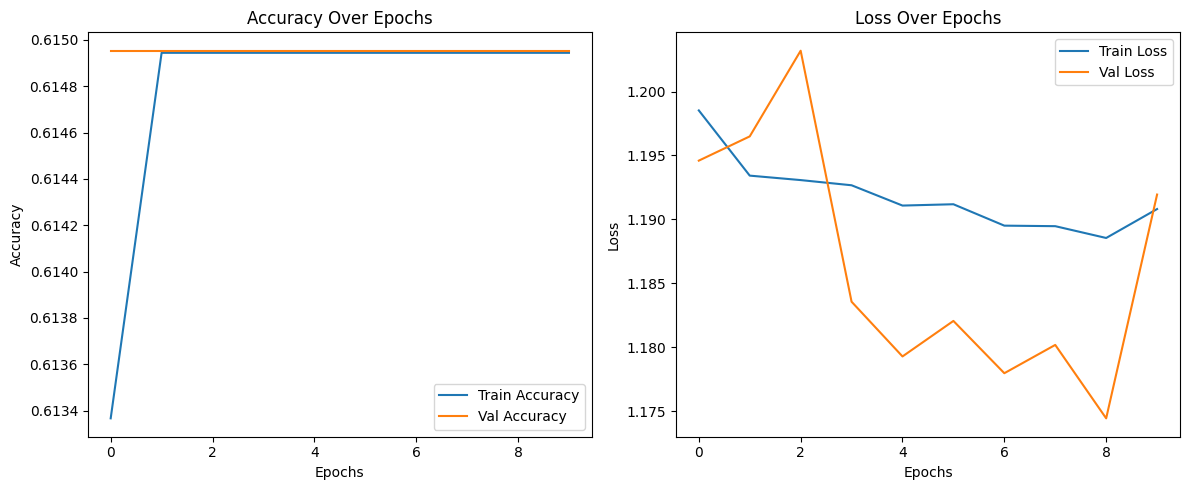

In [12]:
# Plot Accuracy & Loss
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_curves(history)


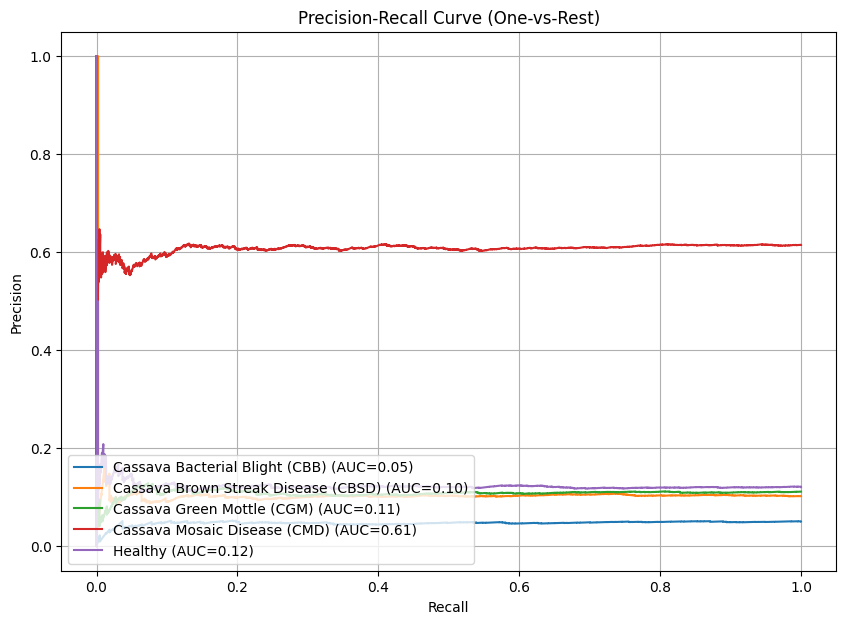

In [13]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc

# Binarize labels
n_classes = 5
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
y_pred_bin = y_pred  # Already softmax output

plt.figure(figsize=(10, 7))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    auc_score = auc(recall, precision)
    plt.plot(recall, precision, label=f"{label_map[str(i)]} (AUC={auc_score:.2f})")

plt.title("Precision-Recall Curve (One-vs-Rest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='lower left')
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


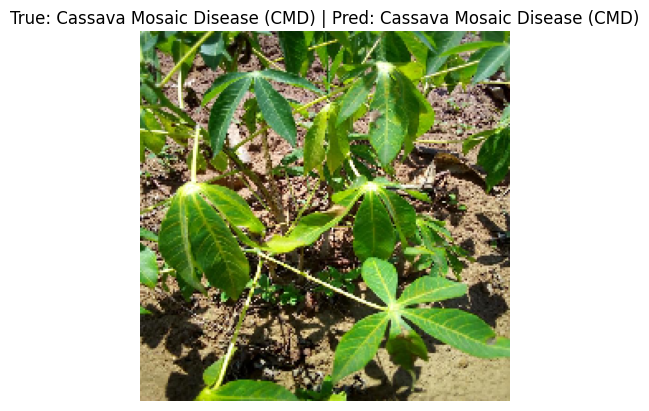

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


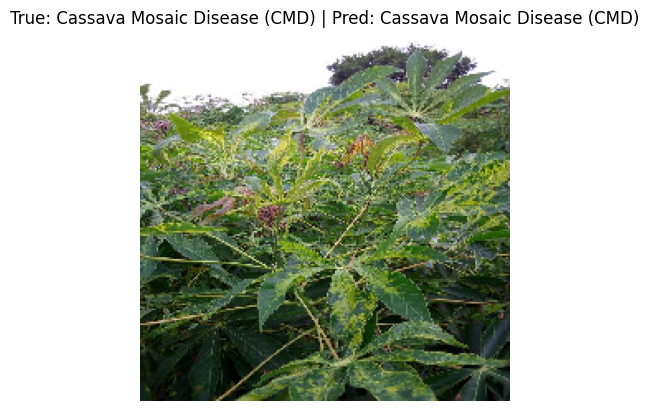

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


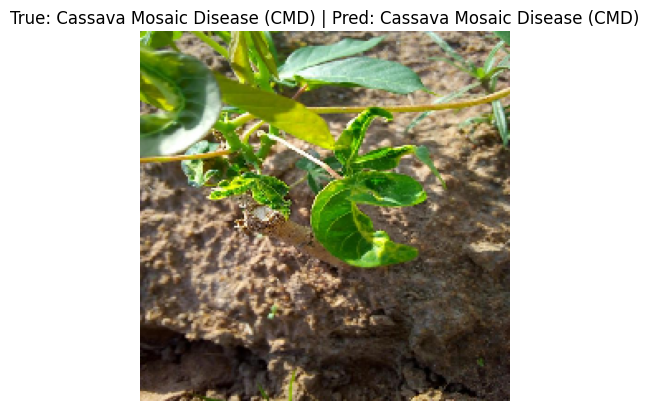

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


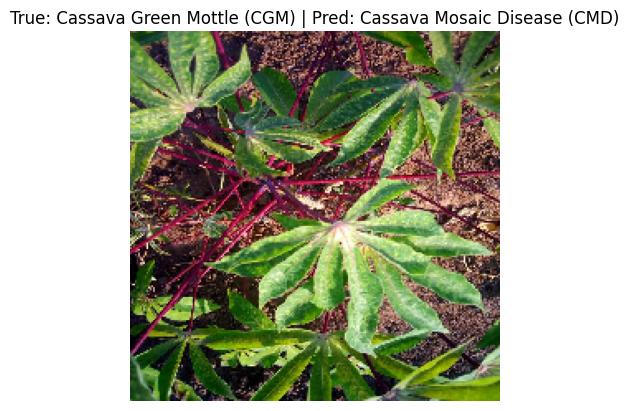

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


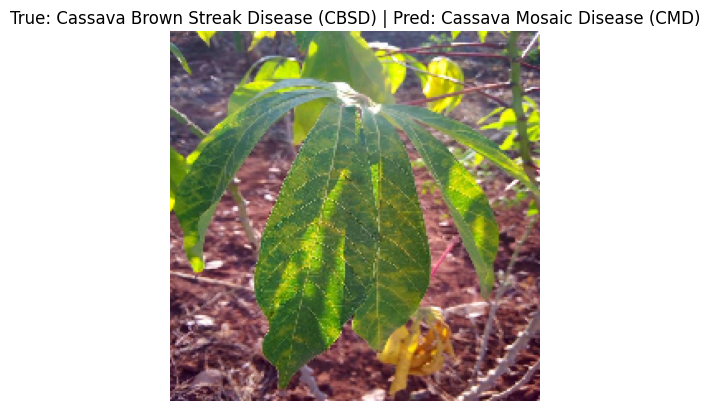

In [14]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_random_samples(model, df, directory, num_samples=5):
    sample = df.sample(num_samples)
    for idx, row in sample.iterrows():
        img_path = os.path.join(directory, row['image_id'])
        img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_array = img_to_array(img) / 255.0
        pred = model.predict(np.expand_dims(img_array, axis=0))
        pred_label = label_map[str(np.argmax(pred))]
        true_label = label_map[row['label']]
        
        plt.imshow(img)
        plt.title(f"True: {true_label} | Pred: {pred_label}")
        plt.axis('off')
        plt.show()

# Run it on val_df
predict_random_samples(model, val_df, '/kaggle/input/cassava-leaf-disease-classification/train_images')